## 라이브러리 import 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
from tensorflow import keras

In [2]:
# 재현성을 위한 코드
random_seed = 777

tf.keras.utils.set_random_seed(random_seed)
# tf.random.normal([5], 0, 1)

## 데이터 불러오기

In [3]:
# 레이블 불러오기
TrainLabel = np.array(pd.read_csv('./ProcessedData/TrainLabel.csv', sep = ",", header = None))
ValidLabel = np.array(pd.read_csv('./ProcessedData/ValidLabel.csv', sep = ",", header = None))

TrainLabel.shape, ValidLabel.shape

((300, 2), (60, 2))

In [4]:
# 데이터 갯수 정의

NoOfData  = 180                    # 데이터 개수
NoOfValid = int(NoOfData/6)        # 검증 데이터 개수
NoOftrain = NoOfData - NoOfValid   # 학습 데이터 개수

NoOfData, NoOfValid, NoOftrain

(180, 30, 150)

In [5]:
# 데이터 길이 정의
DataLength = 2774 # 데이터 길이

DataLength

2774

In [6]:
# 전체 가속도 데이터 만들기

NoOfData   = 180      # 데이터 개수 (정상/고장 각각)
TotalData = np.zeros([NoOfData*2, DataLength]) # 데이터 빈집

for i in range(NoOfData):
    tempNormalPath   = './SpotWeldingData/Normal_%d.csv'%(i+1)
    tempAbnormalPath = './SpotWeldingData/Abnormal_%d.csv'%(i+1)
    tempNormal   = pd.read_csv(tempNormalPath  ).iloc[:,0]  # 가속도 데이터
    tempAbnormal = pd.read_csv(tempAbnormalPath).iloc[:,0]  # 가속도 데이터
    TotalData[i,:]            = tempNormal
    TotalData[i + NoOfData,:] = tempAbnormal

TotalData.shape

(360, 2774)

## STFT 실행 (Spectrogram 생성)

In [7]:
NoOfSensor = 1
Fs         = 12800

In [8]:
# STFT test
f,t,Sxx = signal.spectrogram(TotalData, Fs, nperseg = 99, noverlap = 45)
print("STFT Result            :", Sxx.shape)

STFT Result            : (360, 50, 50)


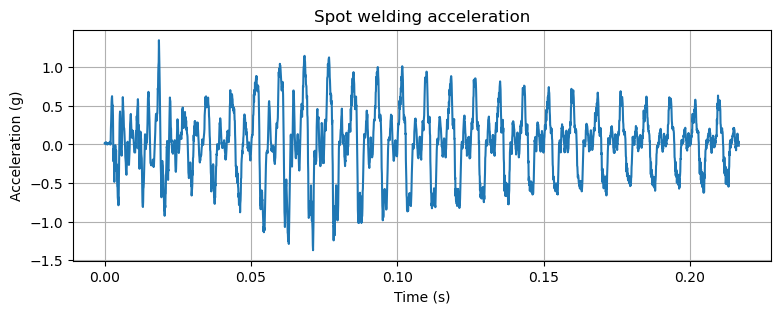

In [9]:
plt.figure(figsize=(9,3))
plt.plot(np.arange(0, 0.2167, 1/12800), TotalData[0,:])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Spot welding acceleration')

plt.show()

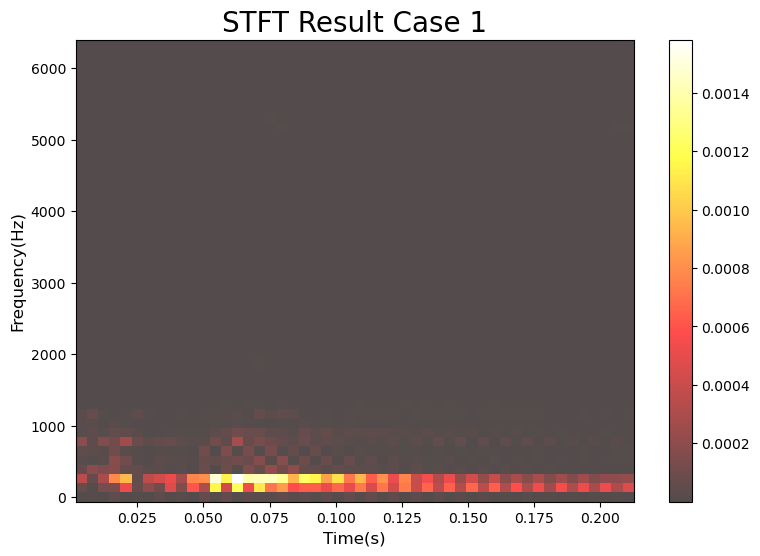

In [10]:
plt.figure(figsize=(9,6))
plt.pcolormesh(t, f, Sxx[0], cmap = 'hot', alpha = 0.7)

plt.xlabel('Time(s)', fontsize=12)
plt.ylabel('Frequency(Hz)', fontsize=12)
plt.title('STFT Result Case 1', fontsize=20)
plt.colorbar()
plt.show()

In [11]:
# Data Reshape for CNN
TotalData_STFT = Sxx.reshape(Sxx.shape[0], Sxx.shape[1], Sxx.shape[2], NoOfSensor)
print("Reshape_for_CNN Result :", TotalData_STFT.shape)

Reshape_for_CNN Result : (360, 50, 50, 1)


## 학습 데이터와 검증 데이터 분할

In [12]:
# 정상/고장 데이터 분할

Normal   = TotalData_STFT[:NoOfData, :, :, :]
Abnormal = TotalData_STFT[NoOfData:, :, :, :]

Normal.shape, Abnormal.shape

((180, 50, 50, 1), (180, 50, 50, 1))

In [13]:
# 정상 및 고장 별 학습/검증 데이터 분할

Normal_train   = Normal[  :NoOftrain, :, :, :]
Abnormal_train = Abnormal[:NoOftrain, :, :, :]

Normal_valid   = Normal[  NoOftrain:, :, :, :]
Abnormal_valid = Abnormal[NoOftrain:, :, :, :]

Normal_train.shape, Abnormal_train.shape, Normal_valid.shape, Abnormal_valid.shape

((150, 50, 50, 1), (150, 50, 50, 1), (30, 50, 50, 1), (30, 50, 50, 1))

In [14]:
# 학습 및 검증 데이터 분할

TrainData = np.concatenate([Normal_train, Abnormal_train], axis = 0)
ValidData = np.concatenate([Normal_valid, Abnormal_valid], axis = 0)

TrainData.shape, ValidData.shape

((300, 50, 50, 1), (60, 50, 50, 1))

## CNN(Convolution Neural Network) hyperparameter 설정

In [15]:
learningRate  = 0.001
Epoch         = 500

## Keras 기반 CNN 구조(Architecture) 설계

In [16]:
def CNN(input_data):
    keras.backend.clear_session()
    tf.keras.utils.set_random_seed(random_seed)

    model = keras.Sequential()
    model.add(keras.layers.InputLayer(shape=(input_data.shape[1],input_data.shape[2],input_data.shape[3])))             # Input layer
    model.add(keras.layers.Conv2D(filters = 4, kernel_size=(3,3), strides=(1, 1), padding='same', activation=keras.activations.relu))  # Convolution layer 1
    model.add(keras.layers.MaxPooling2D(pool_size = (2,2), strides=(2,2)))                                              # Pooling layer 1
    model.add(keras.layers.Conv2D(filters = 8, kernel_size=(3,3), strides=(1, 1), padding='same', activation=keras.activations.relu))   # Convolution layer 2
    
    # Convolution/Pooling layer to Output layer
    model.add(keras.layers.GlobalAveragePooling2D())                                                                    # Global Average Pooling (Simple Structure)

    model.add(keras.layers.Dense(units = 2, activation=keras.activations.softmax))                                      # Output Layer

    model.compile(optimizer= keras.optimizers.Adam(learning_rate = learningRate),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

## CNN(Convolution Neural Network) 학습 및 평가 방법

In [17]:
# 모델 만들기
CNN_model = CNN(TrainData)

# 모델 구조, 파라미터 개수 확인
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 50, 4)           │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 25, 8)           │             296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354 (1.38 KB)

 Trainable params: 354 (1.38 KB)

 Non-trainable params: 0 (0.00 B)

## Keras 기반 CNN 학습 및 평가

In [18]:
# 모델 학습/검증
hist = CNN_model.fit(TrainData, TrainLabel, epochs=Epoch, verbose = 1)
Loss, Accuracy = CNN_model.evaluate(TrainData,  TrainLabel, verbose=0)

print('Final Loss and Accuracy: {:.4f}, {:.2f}%'.format(Loss, Accuracy*100))

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5460 - loss: 0.6931
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5460 - loss: 0.6918
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5460 - loss: 0.6922
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5460 - loss: 0.6926
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5466 - loss: 0.6930
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4540 - loss: 0.6932
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4540 - loss: 0.6934
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4540 - loss: 0.6937
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4540 - loss: 0.6941
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4540 - loss: 0.6943
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4540 - loss: 0.6946
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - a

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4649 - loss: 0.6679
Epoch 70/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5511 - loss: 0.6658
Epoch 71/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4639 - loss: 0.6641
Epoch 72/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4717 - loss: 0.6630
Epoch 73/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5513 - loss: 0.6609
Epoch 74/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5690 - loss: 0.6594
Epoch 75/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9032 - loss: 0.6577
Epoch 76/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7234 - loss: 0.6562
Epoch 77/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6031 - loss: 0.6545
Epoch 78/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6758 - loss: 0.6529
Epoch 79/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9402 - loss: 0.6512
Epoch 80/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6419 - loss: 0.6080
Epoch 137/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6419 - loss: 0.6077
Epoch 138/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6419 - loss: 0.6074
Epoch 139/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6419 - loss: 0.6071
Epoch 140/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6419 - loss: 0.6068
Epoch 141/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6419 - loss: 0.6065
Epoch 142/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6419 - loss: 0.6063
Epoch 143/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6419 - loss: 0.6060
Epoch 144/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6419 - loss: 0.6058
Epoch 145/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6419 - loss: 0.6055
Epoch 146/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6419 - loss: 0.6053
Epoch 147/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6419 - loss: 0.5945
Epoch 204/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6419 - loss: 0.5934
Epoch 205/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6419 - loss: 0.5940
Epoch 206/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6419 - loss: 0.5933
Epoch 207/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6419 - loss: 0.5937
Epoch 208/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6419 - loss: 0.5928
Epoch 209/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6419 - loss: 0.5934
Epoch 210/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6419 - loss: 0.5924
Epoch 211/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6419 - loss: 0.5927
Epoch 212/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6419 - loss: 0.5922
Epoch 213/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6419 - loss: 0.5926
Epoch 214/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/ste

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7128 - loss: 0.5764
Epoch 271/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7128 - loss: 0.5761
Epoch 272/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7128 - loss: 0.5757
Epoch 273/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7149 - loss: 0.5753
Epoch 274/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7177 - loss: 0.5749
Epoch 275/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7177 - loss: 0.5746
Epoch 276/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7299 - loss: 0.5742
Epoch 277/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7299 - loss: 0.5738
Epoch 278/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7299 - loss: 0.5734
Epoch 279/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7343 - loss: 0.5730
Epoch 280/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7371 - loss: 0.5726
Epoch 281/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9389 - loss: 0.5454
Epoch 338/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8876 - loss: 0.5415
Epoch 339/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9402 - loss: 0.5441
Epoch 340/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8817 - loss: 0.5402
Epoch 341/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9402 - loss: 0.5429
Epoch 342/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8817 - loss: 0.5389
Epoch 343/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9411 - loss: 0.5416
Epoch 344/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8875 - loss: 0.5377
Epoch 345/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9367 - loss: 0.5404
Epoch 346/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8875 - loss: 0.5364
Epoch 347/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9367 - loss: 0.5391
Epoch 348/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9420 - loss: 0.4947
Epoch 405/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9469 - loss: 0.4954
Epoch 406/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9530 - loss: 0.4935
Epoch 407/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9555 - loss: 0.4939
Epoch 408/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9486 - loss: 0.4922
Epoch 409/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9521 - loss: 0.4920
Epoch 410/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9499 - loss: 0.4906
Epoch 411/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9555 - loss: 0.4907
Epoch 412/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9499 - loss: 0.4887
Epoch 413/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9555 - loss: 0.4895
Epoch 414/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9549 - loss: 0.4866
Epoch 415/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9604 - loss: 0.4423
Epoch 472/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9572 - loss: 0.4388 
Epoch 473/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9604 - loss: 0.4407
Epoch 474/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9572 - loss: 0.4371
Epoch 475/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9604 - loss: 0.4391
Epoch 476/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9572 - loss: 0.4355
Epoch 477/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9604 - loss: 0.4374
Epoch 478/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9572 - loss: 0.4338
Epoch 479/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9604 - loss: 0.4357
Epoch 480/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9572 - loss: 0.4322
Epoch 481/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9610 - loss: 0.4342 
Epoch 482/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

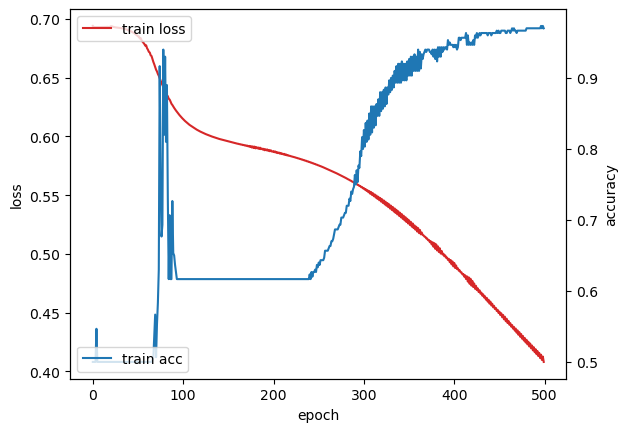

In [19]:
# 학습 과정 확인(Loss, Accuracy)
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], label='train loss', color = "tab:red")
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], label='train acc', color = "tab:blue")
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()

In [20]:
Loss, Accuracy = CNN_model.evaluate(ValidData,  ValidLabel, verbose=0)

print('Validation Accuracy: {:.2f}%'.format(Accuracy*100))

Validation Accuracy: 96.67%


In [21]:
# 모델 저장
CNN_model.save('./MLmodels/CNN_model.keras')

## CNN model 불러와서 진단

In [22]:
# 모델 불러오기
LoadedModel = keras.models.load_model('./MLmodels/CNN_model.keras')

In [23]:
Loss, Accuracy = LoadedModel.evaluate(ValidData,  ValidLabel, verbose=0)

print('[Performance of CNN model] \n')
print('Accuracy : {:.2f}%'.format(Accuracy*100))

[Performance of CNN model] 

Accuracy : 96.67%


## ++. Confusion Matrix 확인

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [25]:
# 분류 결과 확인
Pred = LoadedModel.predict(ValidData)
pd.DataFrame(Pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


,0,1
0,0.750167,2.498329e-01
1,0.712331,2.876686e-01
2,0.503741,4.962591e-01
3,0.605539,3.944608e-01
4,0.577517,4.224832e-01
5,0.527958,4.720422e-01
6,1.000000,0.000000e+00
7,0.623547,3.764534e-01
8,0.634601,3.653994e-01
9,0.574696,4.253042e-01


In [26]:
# One-hot encoding -> Label encoding
true = np.argmax(ValidLabel, axis=-1)
pred = np.argmax(Pred, axis=-1)

# Confusion Matrix 생성
CM = confusion_matrix(true, pred).T

# 데이터의 실제/분류결과 이름
x = ['Normal_True', 'Abnormal_True']
y = ['Normal_Pred', 'Abnormal_Pred']

CM_df = pd.DataFrame(CM,columns=x, index=y)
CM_df

,Normal_True,Abnormal_True
Normal_Pred,29,1
Abnormal_Pred,1,29


C:\Users\BJ\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


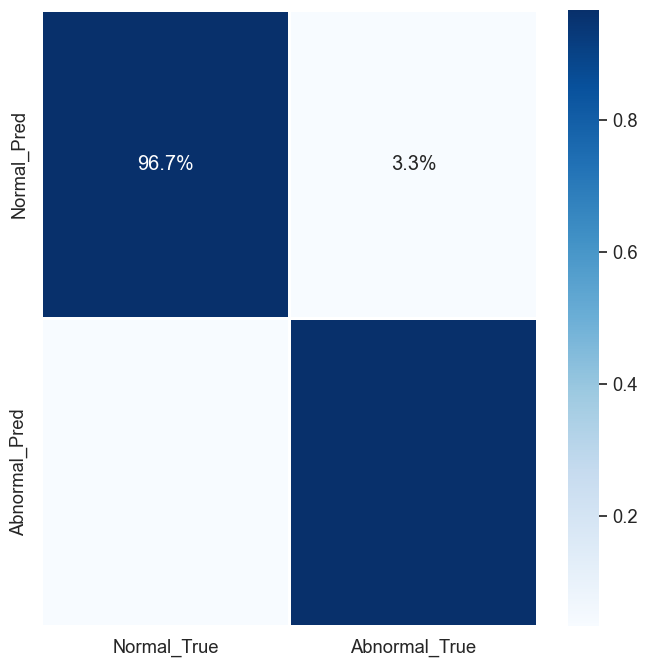

In [27]:
# heatmap font size
sns.set(font_scale=1.2)

# Heatmap 형태로 확인
fig = plt.subplots(figsize=(8,8))


# 퍼센트
sns.heatmap(CM_df/np.sum(CM_df),
            cmap='Blues',          # cmap Color
            annot=True,            # Value Text
            fmt=".1%",             # Value type (integer = "d")
            linewidths=2)

# 갯수
# sns.heatmap(CM_df,
#             cmap='Blues',        # cmap Color
#             annot=True,          # Value Text
#             fmt="d",             # Value type (integer = "d")
#             linewidths=2) 



plt.show()